## Weather and the NFL: Analysis
### Data Collection

The NFL, or National Football League, chooses the locations for its games in a very similar way to other major leagues, the MLB, NBA, NHL, etc; excluding the one super bowl a season and rare international games, each game takes place in one of the particpating team's stadium and facilities. The team whose stadium the game is in is traditionally considered to have an advantage (eg, "home field advantage") which is often represented it betting lines as well. This advantage is thought to be for a variety reasons, however, mainly a biased crowd, and comfort to the regions' weather and temperature.

The most consistent data to judge home field advantage is the temperature when the game occured. In a naive sense, a person who spends months training in 90 degrees F might struggle if a game takes place at 15 degrees F, whereas someone who experiences low temps regularly would be far more accustomed.

***

We start by importing a dataset of the weather data of all NFL games 1963-2013, provided by nflsavant.com. This dataset includes the score of the game, the team participating, the temperaure, etc.

* We define two new columns to the dataframe, the first, points differental, defined by the home teams score minus the away teams score. The differential will be positive if the home team won, negative if they lost, and 0 if the teams tied.

* The second, distance, is the distance, aka how far, the temperature of the game is from the mean of all game temps.


In [179]:
from bs4 import BeautifulSoup
import requests
import pandas
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math

df = pandas.read_csv("http://www.nflsavant.com/dump/weather_20131231.csv")

df['points_diff'] = df.apply(lambda row: row['home_score'] - row['away_score'], axis=1)

df['distance'] = df.apply(lambda row: math.dist((df['temperature'].mean(),), (row['temperature'],)), axis=1)

print(df)


                 id             home_team  home_score            away_team  \
0      196009230ram      Los Angeles Rams          21  St. Louis Cardinals   
1      196009240dal        Dallas Cowboys          28  Pittsburgh Steelers   
2      196009250gnb     Green Bay Packers          14        Chicago Bears   
3      196009250sfo   San Francisco 49ers          19      New York Giants   
4      196009250clt       Baltimore Colts          20  Washington Redskins   
...             ...                   ...         ...                  ...   
11187  201312290nwe  New England Patriots          34        Buffalo Bills   
11188  201312290atl       Atlanta Falcons          20    Carolina Panthers   
11189  201312290pit   Pittsburgh Steelers          20     Cleveland Browns   
11190  201312290rai       Oakland Raiders          14       Denver Broncos   
11191  201312290mia        Miami Dolphins           7        New York Jets   

       away_score  temperature  wind_chill humidity  wind_mph  

### Data Curation

On a logical level, these temperatures would only make a difference in a game if it is signifcantly different from the average temperature, and, the advantage for the home team would be largest at these extremes. As such, we cull the data of games where the temperature was not significantly different from the average temperature. The defintion for these extremes, in this case, are the lowest .5%, and the highest 5% of values. These quantiles were chose to keep temperatures to further distance values, while also keeping the sample size large enough for a meaninfull analysis (~1200 games over 50 years).

***

We first list out the mean, 5% quantile, and 95% quantile. Then, we use the dataframe .drop method to drop all values with this inter-quantile range from the dataframe, and save the result to a new dataframe, extremes. We conversely use the same method to create a frame consisting of values outside this inter-quantile range, saving it as normals.

In [180]:
print(df['temperature'].mean())
print(df['temperature'].quantile(.05))
print(df['temperature'].quantile(.95))

#df.drop(df[(df['temperature'] == 0) & (df['temperature'] )].index, inplace=True)
extremes = df.drop(df[(df['temperature'] < df['temperature'].quantile(.95)) & (df['temperature'] > df['temperature'].quantile(.05))].index)

normals = df.drop(df[(df['temperature'] <= df['temperature'].quantile(.95)) & (df['temperature'] <= df['temperature'].quantile(.05))].index)
print(extremes)

56.68531093638313
28.0
77.0
                 id            home_team  home_score            away_team  \
6      196009300dal       Dallas Cowboys          25  Philadelphia Eagles   
67     196012110cle     Cleveland Browns          42        Chicago Bears   
69     196012110pit  Pittsburgh Steelers          27  Philadelphia Eagles   
71     196012110det        Detroit Lions          23       Dallas Cowboys   
74     196012180det        Detroit Lions          36        Chicago Bears   
...             ...                  ...         ...                  ...   
11178  201312290dal       Dallas Cowboys          22  Philadelphia Eagles   
11179  201312290chi        Chicago Bears          28    Green Bay Packers   
11186  201312290min    Minnesota Vikings          14        Detroit Lions   
11188  201312290atl      Atlanta Falcons          20    Carolina Panthers   
11191  201312290mia       Miami Dolphins           7        New York Jets   

       away_score  temperature  wind_chill humi

### Exploratory Analysis: Scatterplot

First, it is important to see if there are any readily-apparent trends to our data. 

***

So, we first show our points differntials data vs our distance from mean temp dats, for our extremes dataframe. The scatterplot here does not show any apparent trend between the two variables.

<AxesSubplot:title={'center':'Point Differential vs Temp Distance from Mean'}, xlabel='distance', ylabel='points_diff'>

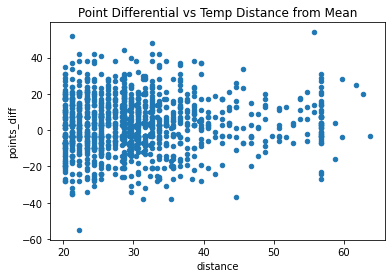

In [181]:
extremes.plot.scatter('distance','points_diff', title='Point Differential vs Temp Distance from Mean')


### Exploratory Analysis: Linear Regression

While our scatterplot may not show any interaction, a more detailed linear regression can ascertain if there is any pattern between the two variables.

***

We use statsmodels OLS regression, to give us a summary of a linear regression. From the results, we first see an R Squared of .003, which indicated almost no pattern between the variables, meaning only .3% of variation in Point Differential can be predicted by distance. Furthermore, we see a p values of 3.546 for our intercept and .179 for our slope of the regression line. At the standard .05 significane, bothe of tehse values are not signifcant. As such, our linear regression does not produce a reliable line. Overall, our linear regession tells that is is unlikely that Point Differential and Distance are associated in extreme temp games. 

In [182]:
model = ols("points_diff ~ distance", data=extremes).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            points_diff   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.571
Date:                Mon, 16 May 2022   Prob (F-statistic):             0.0590
Time:                        16:34:32   Log-Likelihood:                -4985.9
No. Observations:                1216   AIC:                             9976.
Df Residuals:                    1214   BIC:                             9986.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6806      1.461      0.466      0.6

### Hypothesis Test

The most definitive test for our data is a hypothesis test, in this case, a t test. A t test compared two variables, in our case Point Differential in extreme temperature games and point differentials in alll other games, and determine whether the differences between them can be attribution to random chance. 

The results of a t test, mainly a p value, tell us whether or not to reject the null hypothesis. In our instance, the null hypothesis is that that the mean Point Differential from the extreme games and the mean from normal games are equal. The alternate is that they are not equal.

***

Our t test, done using statsmodels, is conducted using the 'unequal' option, since our datasets are of different sizes, extreme the smaller and normal the larger. Our p value is .13, which, at a standard signifcane level of .05, is not significant. As such, there is insuffieicent evidence at .05 significance to reject the null hypothesis.

In [183]:
ttest = ttest_ind(extremes['points_diff'], normals['points_diff'],usevar='unequal')
ttest

(1.5121309608107745, 0.13070742570342214, 1527.3135708076431)

### Conclusions

Due to multiple reasons, it is clear that extreme temperatues do not give the home team a statistically significant advantage. 

* For the scatterplot, we see no correlation. If extreme temps did help home teams, we would expect to see a postitive trend where as temperature didtance from mean became great, the point differentials would become more and more positve. 

* For the linear regression, we would expect to see a positive slope, and a high R Squared, both indicating that increases in distance result in increased point diffs. Instead, we ended up with an extremly low R Squared, and a statistically insigificant regression line.

* Finally, for the hypothesis test, we see that we are unable to reject the null hypothesis that the average point diff for extreme temp and normal games are the same.

So, it is clear that the very real phenomenom of home field advantage is probably not caused by extreme temperatures. However, this does not mean that weather condtions, comfort and biased fans are any less contributers to home field advantage 

